In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"francoparon","key":"7a1b917bfcd61698182b9431221ccc78"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
syedanwarafridi/vehicle-sales-data                            Vehicle Sales Data                                  19MB  2024-02-21 20:16:17          13742        253  1.0              
sudarshan24byte/online-food-dataset                           Online Food Dataset                                  3KB  2024-03-02 18:50:30           3377         53  0.9411765        
arnavvvvv/spotify-music                                       Top Spotify Songs                                   47KB  2024-03-06 05:20:29           3638         56  1.0              
tarunrm09/climate-change-indicators                           Climate chang

In [ ]:
!kaggle datasets download -d simaanjali/emotion-analysis-based-on-text

100% 31.9M/31.9M [00:02<00:00, 20.2MB/s]
100% 31.9M/31.9M [00:02<00:00, 13.5MB/s]


In [ ]:
!unzip emotion-analysis-based-on-text.zip

Archive:  emotion-analysis-based-on-text.zip
  inflating: emotion_sentimen_dataset.csv  


In [ ]:
df = pd.read_csv('emotion_sentimen_dataset.csv')

In [ ]:
df.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839555 entries, 0 to 839554
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  839555 non-null  int64 
 1   text        839555 non-null  object
 2   Emotion     839555 non-null  object
dtypes: int64(1), object(2)
memory usage: 19.2+ MB


In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Inspecting number of labels

labels = df['Emotion'].unique()
labels

array(['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness',
       'fun', 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom'],
      dtype=object)

In [ ]:
mapping = {'hate': 0, 'neutral': 1, 'anger': 2, 'love': 3, 'worry': 4, 'relief': 5, 'happiness': 6, 'fun': 7, 'empty': 8, 'enthusiasm': 9, 'sadness': 10, 'surprise': 11, 'boredom': 12}

In [ ]:
df['label'] = df['Emotion'].map(mapping)
df.head()

,text,Emotion,label
0,i seriously hate one subject to death but now ...,hate,0
1,im so full of life i feel appalled,neutral,1
2,i sit here to write i start to dig out my feel...,neutral,1
3,ive been really angry with r and i feel like a...,anger,2
4,i feel suspicious if there is no one outside l...,neutral,1


In [ ]:
df['text_length'] = df['text'].apply(len)
df.head()

,text,Emotion,label,text_length
0,i seriously hate one subject to death but now ...,hate,0,73
1,im so full of life i feel appalled,neutral,1,34
2,i sit here to write i start to dig out my feel...,neutral,1,131
3,ive been really angry with r and i feel like a...,anger,2,89
4,i feel suspicious if there is no one outside l...,neutral,1,87


In [ ]:
df['number_of_words'] = df['text'].apply(lambda x: len(x.split()))

In [ ]:
df.head()

,text,Emotion,label,text_length,number_of_words
0,i seriously hate one subject to death but now ...,hate,0,73,15
1,im so full of life i feel appalled,neutral,1,34,8
2,i sit here to write i start to dig out my feel...,neutral,1,131,29
3,ive been really angry with r and i feel like a...,anger,2,89,19
4,i feel suspicious if there is no one outside l...,neutral,1,87,16


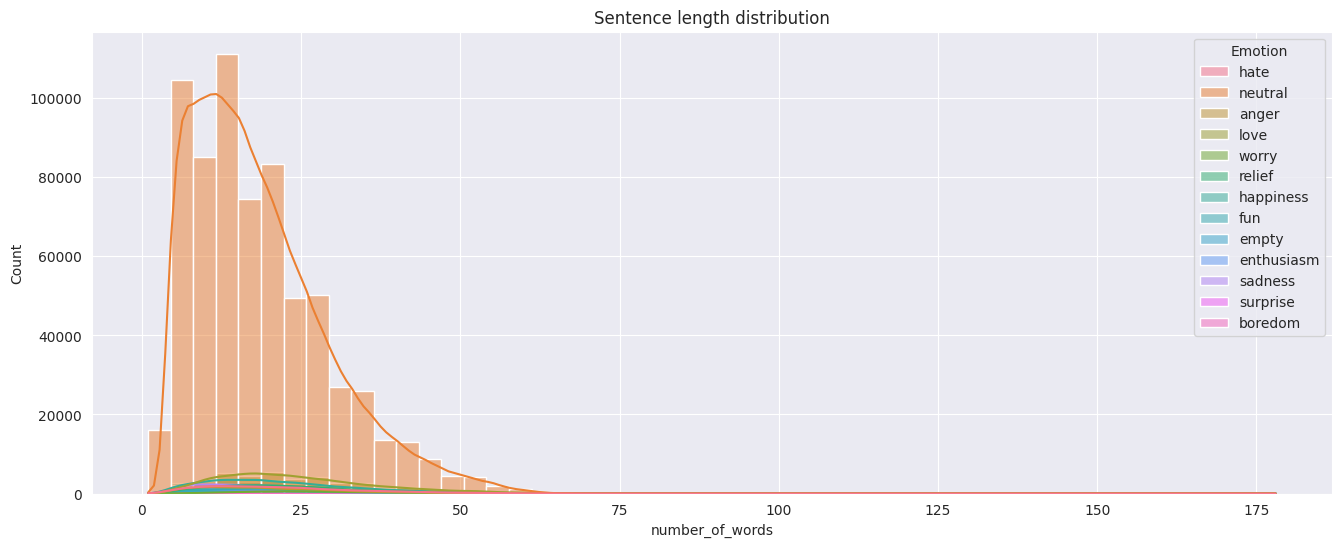

In [ ]:
plt.figure(figsize = (16,6))
sns.set_style('darkgrid')
sns.color_palette('bright')
sns.histplot(x='number_of_words',data=df, hue='Emotion', kde = True, bins=50)
plt.title('Sentence length distribution')
sns.set(font_scale=2)

In [ ]:
## In this case I have decided not to work with the neutral samples

In [ ]:
df_no_neutral = df.loc[df['Emotion']!='neutral']
df_no_neutral.head()

,text,Emotion,label,text_length,number_of_words
0,i seriously hate one subject to death but now ...,hate,0,73,15
3,ive been really angry with r and i feel like a...,anger,2,89,19
5,i feel jealous becasue i wanted that kind of l...,love,3,105,20
7,i finally fell asleep feeling angry useless an...,worry,4,69,12
15,i feel like they hated me since then,hate,0,36,8


In [ ]:
# re-mapping label
remapping = {'hate': 0, 'anger': 1, 'love': 2, 'worry': 3, 'relief': 4, 'happiness': 5, 'fun': 6, 'empty': 7, 'enthusiasm': 8, 'sadness': 9, 'surprise': 10, 'boredom': 11}
df_no_neutral['label'] = df_no_neutral['Emotion'].map(remapping).astype(float)

<ipython-input-147-af423c34c5e8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_neutral['label'] = df_no_neutral['Emotion'].map(remapping).astype(float)


In [ ]:
df_no_neutral.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165017 entries, 0 to 839532
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   text             165017 non-null  object 
 1   Emotion          165017 non-null  object 
 2   label            165017 non-null  float64
 3   text_length      165017 non-null  int64  
 4   number_of_words  165017 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


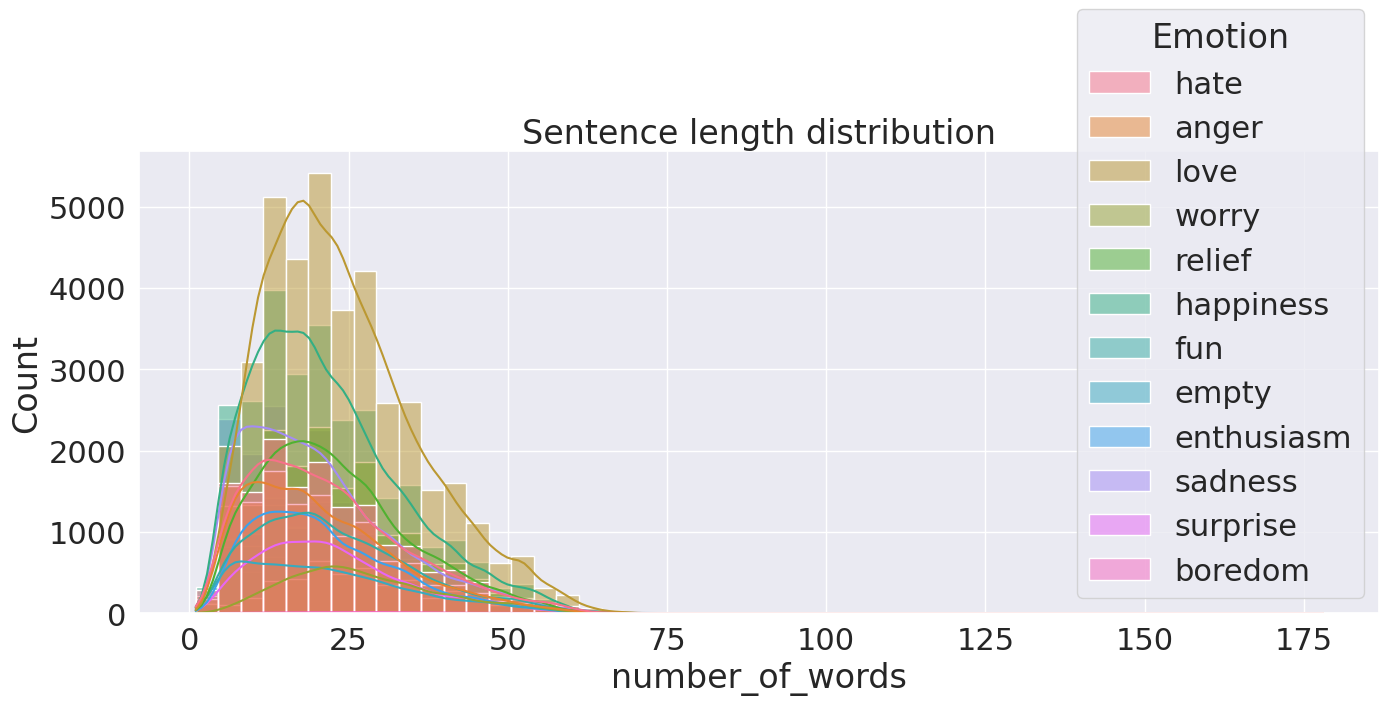

In [ ]:
plt.figure(figsize = (16,6))
sns.set_style('darkgrid')
sns.color_palette('bright')
sns.histplot(x='number_of_words',data=df_no_neutral, hue='Emotion', kde = True, bins=50)
plt.title('Sentence length distribution')
sns.set(font_scale=2)

In [ ]:
Y = df_no_neutral['label'].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_no_neutral['text'], Y, test_size=0.33)

In [ ]:
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
word2idx = tokenizer.word_index
V = len(word2idx) # number of unique elements
print(f'Number of unique words in the dataset: {V}')

Number of unique words in the dataset: 33294


In [ ]:
# padding time!
data_train = pad_sequences(sequences_train)
T = data_train.shape[1]
print(f'Input shape: {T}')

Input shape: 178


In [ ]:
data_test = pad_sequences(sequences_test, maxlen=T)

In [ ]:
# creating the mode
D = 20

i = Input(shape=(T,))
x = Embedding(V+1,D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(12, activation = 'softmax')(x)

model = Model(i,x)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
r = model.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=10)

Epoch 1/10
3456/3456 [==============================] - 128s 37ms/step - loss: 0.5004 - accuracy: 0.8406 - val_loss: 0.0685 - val_accuracy: 0.9852
Epoch 2/10
3456/3456 [==============================] - 121s 35ms/step - loss: 0.0431 - accuracy: 0.9896 - val_loss: 0.0330 - val_accuracy: 0.9912
Epoch 3/10
3456/3456 [==============================] - 124s 36ms/step - loss: 0.0226 - accuracy: 0.9940 - val_loss: 0.0239 - val_accuracy: 0.9936
Epoch 4/10
3456/3456 [==============================] - 112s 32ms/step - loss: 0.0137 - accuracy: 0.9962 - val_loss: 0.0226 - val_accuracy: 0.9945
Epoch 5/10
3456/3456 [==============================] - 122s 35ms/step - loss: 0.0092 - accuracy: 0.9975 - val_loss: 0.0178 - val_accuracy: 0.9958
Epoch 6/10
3456/3456 [==============================] - 121s 35ms/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.0155 - val_accuracy: 0.9965
Epoch 7/10
3456/3456 [==============================] - 110s 32ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0

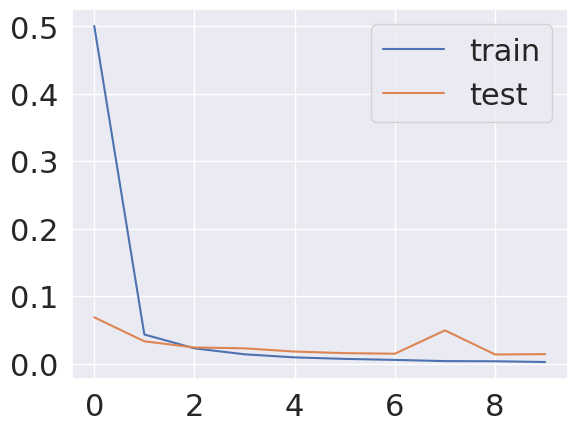

In [ ]:
plt.plot(r.history['loss'], label = 'train')
plt.plot(r.history['val_loss'], label = 'test')
plt.legend()

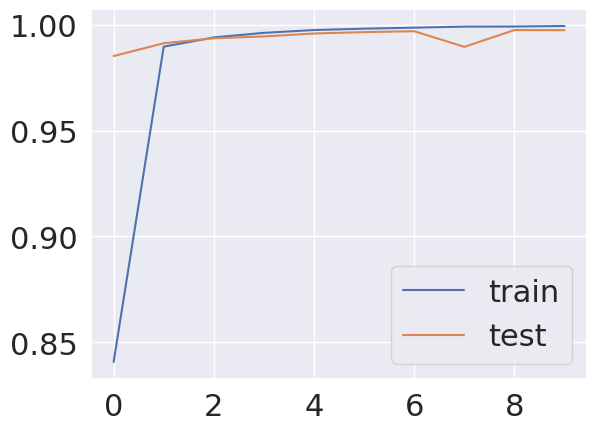

In [ ]:
plt.plot(r.history['accuracy'], label = 'train')
plt.plot(r.history['val_accuracy'], label = 'test')
plt.legend()